# 라이브러리 불러오기

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
import torch
import torch.nn as nn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed as TD
from tensorflow.keras.layers import LSTM, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, VGG19
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20
BATCH_SIZE = 32

# 데이터 경로
data_path = '/content/drive/MyDrive/workspace/4th_project/dataset/'

# 데이터 전처리

In [ ]:

train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

train_df["label"] = train_df["tag"]
test_df["label"] = test_df["tag"]

for index, data in enumerate(train_df["label"].unique()):
    # labe 컴럼에 저장된 data를 index로 변환
    train_df["label"].replace(data, index, inplace=True)

for index, data in enumerate(test_df["label"].unique()):
    # labe 컴럼에 저장된 data를 index로 변환
    test_df["label"].replace(data, index, inplace=True)    

# sklearn.utils.shuffle(train_df) : train_df 행을 섞음
train_df = sklearn.utils.shuffle(train_df)

In [ ]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)

In [ ]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label : 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name, label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20, 224, 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples * MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32")
    # 0으로 초기화된 [비디오 파일개수 * 20]인 배열 생성
    y = np.zeros(shape=(num_samples * MAX_SEQ_LENGTH), dtype="float32")

    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir + path)
        # 프레임의 개수만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index] = np.array(labels[idx], dtype="float32")
            # index 1증가
            index += 1

    # 전체 비디오 프레임을 이미지로 변환한 x
    # to_categorical(y) : 이미지의 종류 y를 onehot 인코딩
    return (x, to_categorical(y))

In [ ]:
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"], data_path + "train/")
X_test, y_test = prepare_all_videos(test_df["video_name"], test_df["label"], data_path + "test/")

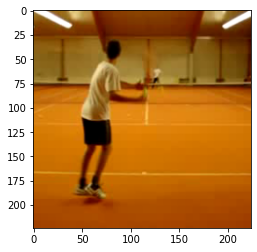

In [ ]:
plt.imshow(X_train[2000]/255)

# 공통 부분

In [ ]:
# 이미지 데이터 생성
train_image_data_generator = ImageDataGenerator(
	horizontal_flip=True,
    rescale=1/255
)

test_image_data_generator = ImageDataGenerator(
    rescale=1/255
)

In [ ]:
# callbacks

# 학습하여 나온 결과가 개선되지 않으면 학습 중단
early_stopping = EarlyStopping(
    monitor='loss',               # 무엇을 감시하고 있을지
    min_delta=1e-4,               # 개선이 되는 것으로 보는 최소값, 이 값보다 작으면 개선이 없는 것
    patience=10,                  # patience의 epochs만큼 진행해도 개선되지 않으면 중단
    verbose=1,                    # 화면 출력 관련
    # mode='min'                  # 여기서는 min이 필요하지만 auto로 알아서 해줌
    # baseline=0.01               # 이것보다 개선되지 않으면 학습 중단
    # restore_best_weights=False  # True: 가장 높게 나온 모델, False: 마지막 학습 모델
)

# 모델 또는 가중치를 저장하기 위한 콜백이나 사용하지 않을 예정입니다. (참고삼아 넣었습니다.)
model_checkpoint = ModelCheckpoint(
    filepath='{가중치를 저장할 경로 입력}',
    monitor='loss'
)

# CNN 모델

In [ ]:
CNN_model = Sequential([
                        
      Conv2D(32, kernel_size=(3,3), input_shape=(224,224,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Conv2D(64, kernel_size=(3,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Conv2D(128, kernel_size=(3,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Dropout(0.5),
      Flatten(),
      Dense(256, activation="relu"),
      Dropout(0.8),
      Dense(3, activation="softmax")
])
CNN_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 28, 28, 128)      

In [ ]:
CNN_model.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/100
222/222 [==============================] - 8s 34ms/step - loss: 0.2842 - acc: 0.8943
Epoch 2/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0252 - acc: 0.9955
Epoch 3/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0119 - acc: 0.9970
Epoch 4/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0067 - acc: 0.9989
Epoch 5/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0058 - acc: 0.9986
Epoch 6/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0056 - acc: 0.9989
Epoch 7/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0029 - acc: 0.9996
Epoch 8/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0050 - acc: 0.9984
Epoch 9/100
222/222 [==============================] - 7s 33ms/step - loss: 0.0027 - acc: 0.9997
Epoch 10/100
222/222 [==============================] - 8s 34ms/step - loss: 8.6073e-04 - acc: 1.0000
Epoch 11/100
222/222 [===

In [ ]:
CNN_model.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 2s 24ms/step - loss: 1.3457 - acc: 0.8099


[1.3457173109054565, 0.8098540306091309]

In [ ]:
CNN_model.save('/content/drive/MyDrive/workspace/4th_project/models/CNN_model.h5')
del CNN_model

# CNN 모델 (BatchNormalization 적용)

In [ ]:
CNN_model_2 = Sequential([
                        
      Conv2D(32, kernel_size=(3,3), input_shape=(224,224,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Conv2D(64, kernel_size=(3,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Conv2D(128, kernel_size=(3,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Dropout(0.5),
      Flatten(),
      Dense(256, activation="relu"),
      BatchNormalization(),
      Dropout(0.8),
      Dense(128, activation="relu"),
      BatchNormalization(),
      Dropout(0.8),
      Dense(64, activation="relu"),
      BatchNormalization(),
      Dropout(0.8),
      Dense(3, activation="softmax")
])
CNN_model_2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

CNN_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 128)      

In [ ]:
CNN_model_2.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=30,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/20
222/222 [==============================] - 9s 36ms/step - loss: 2.0595 - acc: 0.4034
Epoch 2/20
222/222 [==============================] - 8s 35ms/step - loss: 1.7118 - acc: 0.4668
Epoch 3/20
222/222 [==============================] - 8s 36ms/step - loss: 1.4169 - acc: 0.5142
Epoch 4/20
222/222 [==============================] - 8s 35ms/step - loss: 1.2105 - acc: 0.5574
Epoch 5/20
222/222 [==============================] - 8s 36ms/step - loss: 1.0407 - acc: 0.6086
Epoch 6/20
222/222 [==============================] - 8s 36ms/step - loss: 0.8929 - acc: 0.6486
Epoch 7/20
222/222 [==============================] - 8s 35ms/step - loss: 0.7743 - acc: 0.6954
Epoch 8/20
222/222 [==============================] - 8s 35ms/step - loss: 0.6400 - acc: 0.7374
Epoch 9/20
222/222 [==============================] - 8s 35ms/step - loss: 0.5463 - acc: 0.7754
Epoch 10/20
222/222 [==============================] - 8s 35ms/step - loss: 0.4984 - acc: 0.7937
Epoch 11/20
222/222 [==================

In [ ]:
CNN_model_2.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 2s 23ms/step - loss: 0.2678 - acc: 0.9372


[0.26784780621528625, 0.9372262954711914]

In [ ]:
CNN_model_2.save('/content/drive/MyDrive/workspace/4th_project/models/CNN_model(BN=T).h5')
del CNN_model_2

## 재확인 ★

In [ ]:
# BatchNormalization CNN 모델 정의 (BNCNN)
CNN_model_4 = Sequential([
                        
      Conv2D(32, kernel_size=(3,3), input_shape=(224,224,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Conv2D(64, kernel_size=(3,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Conv2D(128, kernel_size=(3,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Dropout(0.5),
      Flatten(),
      Dense(256, activation="relu"),
      BatchNormalization(),
      Dropout(0.8),
      Dense(128, activation="relu"),
      BatchNormalization(),
      Dropout(0.8),
      Dense(64, activation="relu"),
      BatchNormalization(),
      Dropout(0.8),
      Dense(3, activation="softmax")
])
CNN_model_4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

CNN_model_4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 28, 28, 128)      

In [ ]:
CNN_model_4.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=30,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/30
222/222 [==============================] - 10s 39ms/step - loss: 2.3494 - acc: 0.3842
Epoch 2/30
222/222 [==============================] - 8s 36ms/step - loss: 2.0037 - acc: 0.4249
Epoch 3/30
222/222 [==============================] - 8s 36ms/step - loss: 1.6705 - acc: 0.4767
Epoch 4/30
222/222 [==============================] - 8s 36ms/step - loss: 1.3931 - acc: 0.5354
Epoch 5/30
222/222 [==============================] - 8s 36ms/step - loss: 1.2303 - acc: 0.5643
Epoch 6/30
222/222 [==============================] - 8s 37ms/step - loss: 1.0364 - acc: 0.6196
Epoch 7/30
222/222 [==============================] - 8s 36ms/step - loss: 0.8310 - acc: 0.6778
Epoch 8/30
222/222 [==============================] - 8s 36ms/step - loss: 0.7140 - acc: 0.7122
Epoch 9/30
222/222 [==============================] - 8s 36ms/step - loss: 0.5875 - acc: 0.7580
Epoch 10/30
222/222 [==============================] - 8s 37ms/step - loss: 0.5125 - acc: 0.7926
Epoch 11/30
222/222 [=================

In [ ]:
CNN_model_4.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 2s 26ms/step - loss: 0.4496 - acc: 0.8781


[0.4496108889579773, 0.87810218334198]

# CNN 모델 (SeparableConv2D)

In [ ]:

# CNN_model_3 = Sequential([
                        
#       SeparableConv2D(32, kernel_size=(3,3), input_shape=(224,224,3), activation="relu", padding="SAME"),
#       SeparableConv2D(64, kernel_size=(3,3), activation="relu", padding="SAME"),
#       MaxPooling2D(pool_size=2, padding="SAME"),
#       SeparableConv2D(64, kernel_size=(3,3), activation="relu", padding="SAME"),
#       SeparableConv2D(128, kernel_size=(3,3), activation="relu", padding="SAME"),
#       MaxPooling2D(pool_size=2, padding="SAME"),

#       SeparableConv2D(64, kernel_size=(3,3), activation="relu", padding="SAME"),
#       SeparableConv2D(128, kernel_size=(3,3), activation="relu", padding="SAME"),
#       GlobalAveragePooling2D(),
#       # Dropout(0.5),

#       # Flatten(),
#       Dense(32, activation="relu"),
#       # Dropout(0.8),
#       Dense(3, activation="softmax")
# ])
# CNN_model_3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

# CNN_model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_12 (Separab (None, 224, 224, 32)      155       
_________________________________________________________________
separable_conv2d_13 (Separab (None, 224, 224, 64)      2400      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
separable_conv2d_14 (Separab (None, 112, 112, 64)      4736      
_________________________________________________________________
separable_conv2d_15 (Separab (None, 112, 112, 128)     8896      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
separable_conv2d_16 (Separab (None, 56, 56, 64)       

In [ ]:
CNN_model_3 = Sequential([
                        
      SeparableConv2D(32, kernel_size=(3,3), input_shape=(224,224,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      SeparableConv2D(64, kernel_size=(3,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      SeparableConv2D(128, kernel_size=(3,3), activation="relu", padding="SAME"),
      MaxPooling2D(pool_size=2, padding="SAME"),
      Dropout(0.5),
      Flatten(),
      Dense(256, activation="relu"),
      Dropout(0.8),
      Dense(3, activation="softmax")
])
CNN_model_3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

CNN_model_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_18 (Separab (None, 224, 224, 32)      155       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
separable_conv2d_19 (Separab (None, 112, 112, 64)      2400      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
separable_conv2d_20 (Separab (None, 56, 56, 128)       8896      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 28, 28, 128)      

In [ ]:
CNN_model_3.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/100
222/222 [==============================] - 34s 150ms/step - loss: 0.7268 - acc: 0.7126
Epoch 2/100
222/222 [==============================] - 33s 149ms/step - loss: 0.2926 - acc: 0.9069
Epoch 3/100
222/222 [==============================] - 33s 149ms/step - loss: 0.1440 - acc: 0.9650
Epoch 4/100
222/222 [==============================] - 33s 149ms/step - loss: 0.0866 - acc: 0.9795
Epoch 5/100
222/222 [==============================] - 34s 151ms/step - loss: 0.0515 - acc: 0.9901
Epoch 6/100
222/222 [==============================] - 34s 152ms/step - loss: 0.0336 - acc: 0.9932
Epoch 7/100
222/222 [==============================] - 34s 151ms/step - loss: 0.0237 - acc: 0.9951
Epoch 8/100
222/222 [==============================] - 33s 150ms/step - loss: 0.0173 - acc: 0.9970
Epoch 9/100
222/222 [==============================] - 33s 150ms/step - loss: 0.0124 - acc: 0.9977
Epoch 10/100
222/222 [==============================] - 33s 150ms/step - loss: 0.0100 - acc: 0.9984
Epoch 11/

In [ ]:
CNN_model_3.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 2s 26ms/step - loss: 1.1608 - acc: 0.7522


[1.1607692241668701, 0.7521897554397583]

In [ ]:
CNN_model_3.save('/content/drive/MyDrive/workspace/4th_project/models/CNN_model_3.h5')
del CNN_model_3

# ResNet50 모델

In [ ]:
# ResNet50 모델 정의 (resnet50_model)
resnet50_model = ResNet50(include_top=True, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling=max, classes=3)

resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
resnet50_model.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/100
222/222 [==============================] - 46s 183ms/step - loss: 0.1683 - acc: 0.9472
Epoch 2/100
222/222 [==============================] - 40s 181ms/step - loss: 0.0199 - acc: 0.9944
Epoch 3/100
222/222 [==============================] - 40s 181ms/step - loss: 0.0166 - acc: 0.9952
Epoch 4/100
222/222 [==============================] - 40s 180ms/step - loss: 0.0343 - acc: 0.9884
Epoch 5/100
222/222 [==============================] - 40s 180ms/step - loss: 0.0025 - acc: 0.9990
Epoch 6/100
222/222 [==============================] - 40s 180ms/step - loss: 0.0309 - acc: 0.9894
Epoch 7/100
222/222 [==============================] - 40s 181ms/step - loss: 0.0015 - acc: 0.9996
Epoch 8/100
222/222 [==============================] - 40s 180ms/step - loss: 0.0124 - acc: 0.9960
Epoch 9/100
222/222 [==============================] - 40s 181ms/step - loss: 0.0037 - acc: 0.9987
Epoch 10/100
222/222 [==============================] - 40s 181ms/step - loss: 0.0113 - acc: 0.9970
Epoch 11/

In [ ]:
resnet50_model.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 6s 67ms/step - loss: 1.3404 - acc: 0.7215


[1.3404048681259155, 0.7215328216552734]

In [ ]:
resnet50_model.save('/content/drive/MyDrive/workspace/4th_project/models/Resnet50_model.h5')
del resnet50_model

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# VGG16 모델

In [ ]:
# VGG16 모델 정의 (vgg16_model)
# 참고 : https://eremo2002.tistory.com/57?category=779320
vgg16_model = Sequential([
    VGG16(weights='imagenet', include_top=True),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])

vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

vgg16_model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              4100096   
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
Total params: 152,949,547
Trainable params: 152,949,547

In [ ]:
vgg16_model.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/100
222/222 [==============================] - 57s 233ms/step - loss: 1.0991 - acc: 0.3385
Epoch 2/100
222/222 [==============================] - 50s 223ms/step - loss: 1.0989 - acc: 0.3349
Epoch 3/100
222/222 [==============================] - 50s 223ms/step - loss: 1.0989 - acc: 0.3385
Epoch 4/100
222/222 [==============================] - 49s 223ms/step - loss: 1.0988 - acc: 0.3366
Epoch 5/100
222/222 [==============================] - 49s 223ms/step - loss: 1.0987 - acc: 0.3393
Epoch 6/100
222/222 [==============================] - 49s 223ms/step - loss: 1.0989 - acc: 0.3385
Epoch 7/100
222/222 [==============================] - 50s 223ms/step - loss: 1.0988 - acc: 0.3320
Epoch 8/100
222/222 [==============================] - 50s 223ms/step - loss: 1.0988 - acc: 0.3404
Epoch 9/100
222/222 [==============================] - 50s 223ms/step - loss: 1.0986 - acc: 0.3348
Epoch 10/100
222/222 [==============================] - 50s 223ms/step - loss: 1.0986 - acc: 0.3403
Epoch 11/

In [ ]:
vgg16_model.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 8s 94ms/step - loss: 1.0999 - acc: 0.2847


[1.0999277830123901, 0.2846715450286865]

In [ ]:
vgg16_model.save('/content/drive/MyDrive/workspace/4th_project/models/Vgg16_model.h5')
del vgg16_model

# VGG16 모델_02 ( input_shape 넣고 include_top=False )

In [ ]:
# VGG16 모델 정의 (vgg16_model)
# 참고 : https://eremo2002.tistory.com/57?category=779320
vgg16_model = Sequential([
    VGG16(weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top= False),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])

vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 3075      
Total params: 127,971,139
Trainable params: 127,971,139

In [ ]:
vgg16_model.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/100
222/222 [==============================] - 50s 220ms/step - loss: 0.0964 - acc: 0.9650
Epoch 2/100
222/222 [==============================] - 49s 221ms/step - loss: 0.0642 - acc: 0.9846
Epoch 3/100
222/222 [==============================] - 49s 220ms/step - loss: 8.4388e-06 - acc: 1.0000
Epoch 4/100
222/222 [==============================] - 49s 221ms/step - loss: 2.3101e-06 - acc: 1.0000
Epoch 5/100
222/222 [==============================] - 49s 220ms/step - loss: 1.5848e-06 - acc: 1.0000
Epoch 6/100
222/222 [==============================] - 49s 221ms/step - loss: 6.2826e-07 - acc: 1.0000
Epoch 7/100
222/222 [==============================] - 49s 220ms/step - loss: 4.0705e-07 - acc: 1.0000
Epoch 8/100
222/222 [==============================] - 49s 220ms/step - loss: 2.9873e-07 - acc: 1.0000
Epoch 9/100
222/222 [==============================] - 49s 220ms/step - loss: 1.7427e-07 - acc: 1.0000
Epoch 10/100
222/222 [==============================] - 49s 220ms/step - loss: 1.

In [ ]:
vgg16_model.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 6s 70ms/step - loss: 1.2063 - acc: 0.8478


[1.206319808959961, 0.8478102087974548]

In [ ]:
vgg16_model.save('/content/drive/MyDrive/workspace/4th_project/models/Vgg16_model_02.h5')
del vgg16_model

# VGG 19모델 ★

In [ ]:
vgg19_model = Sequential([
    VGG19(weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top= False),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])

vgg19_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

vgg19_model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
Total params: 133,280,835
Trainable params: 133,280,835
N

In [ ]:
vgg19_model.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/100
222/222 [==============================] - 80s 266ms/step - loss: 0.1680 - acc: 0.9355
Epoch 2/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0278 - acc: 0.9917
Epoch 3/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0459 - acc: 0.9872
Epoch 4/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0110 - acc: 0.9977
Epoch 5/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0027 - acc: 0.9992
Epoch 6/100
222/222 [==============================] - 57s 255ms/step - loss: 1.1030e-04 - acc: 1.0000
Epoch 7/100
222/222 [==============================] - 57s 256ms/step - loss: 1.8666e-06 - acc: 1.0000
Epoch 8/100
222/222 [==============================] - 57s 256ms/step - loss: 9.8643e-07 - acc: 1.0000
Epoch 9/100
222/222 [==============================] - 57s 256ms/step - loss: 6.0336e-07 - acc: 1.0000
Epoch 10/100
222/222 [==============================] - 57s 256ms/step - loss: 3.3500e-07 - a

In [ ]:
vgg19_model.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 9s 105ms/step - loss: 1.2807 - acc: 0.8923


[1.2806978225708008, 0.8923357725143433]

In [ ]:
vgg19_model.save('/content/drive/MyDrive/workspace/4th_project/models/Vgg19_model.h5')
del vgg19_model

# BNVGG19 모델 (성능저하)

In [ ]:
BNvgg19_model = Sequential([
    VGG19(weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top= False),
    Flatten(),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dense(2048, activation='relu'),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

BNvgg19_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

BNvgg19_model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________

In [ ]:
BNvgg19_model.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/100
222/222 [==============================] - 80s 266ms/step - loss: 0.0800 - acc: 0.9743
Epoch 2/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0115 - acc: 0.9960
Epoch 3/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0602 - acc: 0.9852
Epoch 4/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0166 - acc: 0.9951
Epoch 5/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0061 - acc: 0.9983
Epoch 6/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0011 - acc: 0.9999
Epoch 7/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0012 - acc: 0.9996
Epoch 8/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0036 - acc: 0.9984
Epoch 9/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0866 - acc: 0.9777
Epoch 10/100
222/222 [==============================] - 57s 256ms/step - loss: 0.0077 - acc: 0.9976
Epoch 11/

In [ ]:
BNvgg19_model.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 9s 105ms/step - loss: 9.0424 - acc: 0.7350


[9.04240894317627, 0.7350364923477173]

In [ ]:
BNvgg19_model.save('/content/drive/MyDrive/workspace/4th_project/models/Vgg19_model_2.h5')
del BNvgg19_model

# AlexNet 모델

In [ ]:
num_classes = 3
class AlexNet(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(96, kernel_size = (11, 11), strides = 4, padding = "valid", activation = "relu", input_shape = input_shape, kernel_initializer = "he_normal"))
    self.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "valid", data_format = "channels_last"))

    self.add(Conv2D(256, kernel_size = (5, 5), strides = 1, padding = "same", activation = "relu", kernel_initializer = "he_normal"))
    self.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "valid", data_format = "channels_last"))

    self.add(Conv2D(384, kernel_size = (3, 3), strides = 1, padding = "same", activation = "relu", kernel_initializer = "he_normal"))

    self.add(Conv2D(384, kernel_size = (3, 3), strides = 1, padding = "same", activation = "relu", kernel_initializer = "he_normal"))

    self.add(Conv2D(256, kernel_size = (3, 3), strides = 1, padding = "same", activation = "relu", kernel_initializer = "he_normal"))

    self.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "valid", data_format = "channels_last"))


    self.add(Flatten())
    self.add(Dense(4096, activation = "relu"))
    self.add(Dense(4096, activation = "relu"))
    self.add(Dense(1000, activation = "relu"))
    self.add(Dense(num_classes, activation = "softmax"))

    self.compile(
        optimizer = tf.keras.optimizers.Adam(0.001)
        , loss = "categorical_crossentropy"
        , metrics = ["accuracy"])

In [ ]:
alexnet_model = AlexNet((IMG_SIZE, IMG_SIZE, 3), num_classes)
alexnet_model.summary()

Model: "alex_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 256)       8

In [ ]:
alexnet_model.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/100
222/222 [==============================] - 40s 33ms/step - loss: 1.0509 - accuracy: 0.8507
Epoch 2/100
222/222 [==============================] - 7s 33ms/step - loss: 0.3698 - accuracy: 0.8939
Epoch 3/100
222/222 [==============================] - 7s 33ms/step - loss: 0.3170 - accuracy: 0.8778
Epoch 4/100
222/222 [==============================] - 7s 34ms/step - loss: 0.2362 - accuracy: 0.9386
Epoch 5/100
222/222 [==============================] - 7s 33ms/step - loss: 0.0195 - accuracy: 0.9934
Epoch 6/100
222/222 [==============================] - 7s 33ms/step - loss: 0.0100 - accuracy: 0.9973
Epoch 7/100
222/222 [==============================] - 7s 33ms/step - loss: 1.4156e-05 - accuracy: 1.0000
Epoch 8/100
222/222 [==============================] - 7s 33ms/step - loss: 4.5328e-05 - accuracy: 1.0000
Epoch 9/100
222/222 [==============================] - 7s 33ms/step - loss: 0.1571 - accuracy: 0.9591
Epoch 10/100
222/222 [==============================] - 7s 33ms/step - lo

In [ ]:
alexnet_model.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 2s 26ms/step - loss: 2.6076 - accuracy: 0.7858


[2.6075661182403564, 0.7857664227485657]

In [ ]:
alexnet_model.save('/content/drive/MyDrive/workspace/4th_project/models/AlexNet_model.h5')
del alexnet_model

# LeNet-5 모델 ★

In [ ]:
num_classes = 3
class LeNet(Sequential):
  def __init__(self, input_shape, nb_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = "relu", input_shape = input_shape, padding = "same"))
    self.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

    self.add(Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation = "relu", padding = "valid"))
    self.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

    self.add(Flatten())
    self.add(Dense(120, activation = "relu"))
    self.add(Dense(84, activation = "relu"))
    self.add(Dense(nb_classes, activation = "softmax"))

    self.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

In [ ]:
lenet5_model = LeNet((IMG_SIZE, IMG_SIZE, 3), num_classes)
lenet5_model.summary()

Model: "le_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 224, 224, 6)       456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 112, 112, 6)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 108, 108, 16)      2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 46656)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 120)               5598840   
_________________________________________________________________
dense_18 (Dense)             (None, 84)                101

In [ ]:
lenet5_model.fit(
    train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE,
)

Epoch 1/100
222/222 [==============================] - 8s 31ms/step - loss: 0.1123 - accuracy: 0.9626
Epoch 2/100
222/222 [==============================] - 7s 32ms/step - loss: 1.8717e-04 - accuracy: 1.0000
Epoch 3/100
222/222 [==============================] - 7s 32ms/step - loss: 4.6084e-05 - accuracy: 1.0000
Epoch 4/100
222/222 [==============================] - 7s 32ms/step - loss: 2.6962e-05 - accuracy: 1.0000
Epoch 5/100
222/222 [==============================] - 7s 31ms/step - loss: 1.4063e-05 - accuracy: 1.0000
Epoch 6/100
222/222 [==============================] - 7s 31ms/step - loss: 9.5795e-06 - accuracy: 1.0000
Epoch 7/100
222/222 [==============================] - 7s 31ms/step - loss: 6.9993e-06 - accuracy: 1.0000
Epoch 8/100
222/222 [==============================] - 7s 31ms/step - loss: 5.5308e-06 - accuracy: 1.0000
Epoch 9/100
222/222 [==============================] - 7s 31ms/step - loss: 3.8816e-06 - accuracy: 1.0000
Epoch 10/100
222/222 [============================

In [ ]:
lenet5_model.evaluate(
    test_image_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)
)

86/86 [==============================] - 2s 25ms/step - loss: 0.4328 - accuracy: 0.8814


[0.4327804744243622, 0.8813868761062622]

In [ ]:
lenet5_model.save('/content/drive/MyDrive/workspace/4th_project/models/LeNet5_model.h5')
del lenet5_model

# 토치 테스트 (보류)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [ ]:
# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, input_shape, nb_classes):
        super().__init__()
        self.with_BN = with_BN

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(planes) 

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # 단순한 identity mapping인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            modules = [nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
            if with_BN:
                modules.append(nn.BatchNorm2d(planes))
            self.shortcut = nn.Sequential(*modules)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
        else:
            out = F.relu(self.conv1(x))
            out = self.conv2(out)
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, with_BN, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.with_BN = with_BN

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, with_BN, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, with_BN, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, with_BN, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, with_BN, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, with_BN, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, with_BN, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
        else:
            out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18(with_BN):
    return ResNet(BasicBlock, [2, 2, 2, 2], with_BN)

In [ ]:
criterion = nn.CrossEntropyLoss() # 분류(classification) 문제


def train(net, optimizer, epoch, step):
    net.train()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    steps = [] # 학습 스텝(step)
    losses = [] # 각 스텝에서의 손실(loss)

    for _, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        steps.append(step)
        losses.append(loss.item())
        step += 1

    return correct / total, steps, losses


def test(net, optimizer, epoch):
    net.eval()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    loss = 0 # 손실(loss)

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return correct / total, loss

In [ ]:
print('모델 파라미터를 초기화합니다.')
net = ResNet18(with_BN=False).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수:', total_params)

모델 파라미터를 초기화합니다.
학습 가능한 총 파라미터 수: 11164362


In [ ]:

without_BN_train_accuracies = []
without_BN_steps = []
without_BN_train_losses = []
without_BN_test_accuracies = []
without_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps))
    without_BN_train_accuracies.append(train_accuracy)
    without_BN_steps.extend(steps)
    without_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    without_BN_test_accuracies.append(test_accuracy)
    without_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train accuracy = 12.97 / Train loss = 880.830331325531
Test accuracy = 21.40 / Test loss = 211.96023297309875
[ Epoch: 1/20 ]
Train accuracy = 24.42 / Train loss = 793.0859863758087
Test accuracy = 30.40 / Test loss = 187.24046230316162
[ Epoch: 2/20 ]
Train accuracy = 32.06 / Train loss = 715.54345870018
Test accuracy = 37.03 / Test loss = 170.0979276895523
[ Epoch: 3/20 ]
Train accuracy = 38.01 / Train loss = 656.5042729377747
Test accuracy = 44.63 / Test loss = 151.29651260375977
[ Epoch: 4/20 ]
Train accuracy = 43.17 / Train loss = 605.4968495368958
Test accuracy = 43.02 / Test loss = 154.85873293876648
[ Epoch: 5/20 ]
Train accuracy = 47.78 / Train loss = 562.6603934764862
Test accuracy = 49.48 / Test loss = 141.427778840065
[ Epoch: 6/20 ]
Train accuracy = 51.73 / Train loss = 523.4231567382812
Test accuracy = 54.50 / Test loss = 127.52373492717743
[ Epoch: 7/20 ]
Train accuracy = 55.01 / Train loss = 492.8678175210953
Test accuracy = 56.72 / Test loss = 119.7876245379448
[ Epoch

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
train_loader